In [1]:
import gymnasium as gym
from gymnasium import spaces

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

ticker = "MSFT"
df = yf.download(ticker, period='60d', interval="2m")

df.columns = [i[0] for i in df.columns]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
# Function to compute RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute MACD
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

# Compute Indicators
df["SMA_10"] = df["High"].rolling(window=10).mean()
df["EMA_10"] = df["High"].ewm(span=10, adjust=False).mean()
df["RSI_14"] = compute_rsi(df["High"], window=14)
df["MACD"], df["Signal_Line"] = compute_macd(df["High"])
df["BB_Mid"] = df["High"].rolling(window=20).mean()
df["BB_Std"] = df["High"].rolling(window=20).std()
df["BB_Upper"] = df["BB_Mid"] + (df["BB_Std"] * 2)
df["BB_Lower"] = df["BB_Mid"] - (df["BB_Std"] * 2)

price_volume = (df["High"] * df["Volume"]).rolling(window=20).sum().shift(1)
volume_sum = df["Volume"].rolling(window=20).sum().shift(1)
df["VWAP"] = price_volume / volume_sum


fib_window = 26  # adjust to match your feature engineering style

rolling_high = df["High"].rolling(window=fib_window).max().shift(1)
rolling_low = df["Low"].rolling(window=fib_window).min().shift(1)

df["Fib_23.6"] = rolling_low + 0.236 * (rolling_high - rolling_low)
df["Fib_38.2"] = rolling_low + 0.382 * (rolling_high - rolling_low)
df["Fib_61.8"] = rolling_low + 0.618 * (rolling_high - rolling_low)

df.drop(columns=["BB_Std"], inplace=True)

# Shift indicators to prevent data leakage

for col in ["SMA_10", "EMA_10", "RSI_14", "MACD", "Signal_Line", "VWAP", "BB_Mid", "BB_Upper", "BB_Lower"]:
    df[col] = df[col].shift(1)

# Drop NaN values resulting from rolling calculations
df.dropna(inplace=True)


In [4]:
df

,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,BB_Mid,BB_Upper,BB_Lower,VWAP,Fib_23.6,Fib_38.2,Fib_61.8
Datetime,,,,,,,,,,,,,,,,,
2025-03-03 15:22:00+00:00,394.140015,394.535187,393.691193,393.820007,106536,393.762250,393.936588,39.770921,-0.947974,-1.037332,394.425993,396.327067,392.524919,394.680206,393.720293,394.694846,396.270150
2025-03-03 15:24:00+00:00,394.054993,394.479889,393.859985,394.220001,79951,393.867767,394.045424,50.510883,-0.839062,-0.997678,394.354878,396.115990,392.593767,394.542172,393.526772,394.381603,395.763386
2025-03-03 15:26:00+00:00,394.425995,394.750000,393.859985,394.054993,86296,393.931757,394.124418,54.943700,-0.748581,-0.947859,394.290373,395.923069,392.657677,394.467633,393.392250,394.163860,395.411121
2025-03-03 15:28:00+00:00,394.625000,394.682007,394.149994,394.429993,63936,394.030756,394.238160,53.436186,-0.647614,-0.887810,394.222878,395.637669,392.808086,394.398890,393.176315,393.814339,394.845665
2025-03-03 15:30:00+00:00,394.350006,395.000000,394.279999,394.614990,97494,394.175806,394.318859,57.839074,-0.566552,-0.823558,394.154478,395.304917,393.004040,394.291776,393.138857,393.753707,394.747575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-15 19:50:00+00:00,385.609985,385.769989,384.399994,384.500000,148931,385.311203,385.166560,33.508927,-0.198135,-0.112981,385.415334,386.091956,384.738711,385.429727,384.657353,384.934110,385.381472
2025-04-15 19:52:00+00:00,385.700012,386.000000,385.500000,385.560913,94713,385.318213,385.276274,48.099261,-0.139405,-0.118266,385.437334,386.130679,384.743989,385.390487,384.612375,384.861308,385.263692
2025-04-15 19:54:00+00:00,385.984985,386.070007,385.369995,385.670013,202505,385.349213,385.407861,59.725483,-0.073455,-0.109304,385.468834,386.205207,384.732460,385.441966,384.632433,384.893775,385.316217


In [5]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd

## Step is to trade one stock at a time

In [7]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_cash=1000, initial_stock=10, context_width=10, offset=3):
        super(TradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.initial_stock = initial_stock
        self.context_width = context_width
        self.offset = offset

        self.num_features = df.shape[1]
        self.action_space = spaces.Discrete(3)  # Hold, Buy, Sell

        # 2D observation: [context_width x (features + cash/stock)]
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.context_width, self.num_features + 2),
            dtype=np.float32
        )

        # For reward shaping
        self.hold_duration = 0
        self.net_worths = []
        self.all_episode_net_worths = []

        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.context_width
        self.cash = self.initial_cash
        self.stock_held = self.initial_stock
        self.hold_duration = 0
        self.net_worths = []

        if seed is not None:
            np.random.seed(seed)

        obs = self._get_obs()
        return obs, {}

    def _get_obs(self):
        window = self.df.iloc[self.current_step - self.context_width:self.current_step].values.astype(np.float32)
        cash_stock = np.array([[self.cash, self.stock_held]] * self.context_width, dtype=np.float32)
        obs = np.concatenate((window, cash_stock), axis=1)
        return obs

    def step(self, action):
        terminated = False
        truncated = False
        info = {}

        current_price = self.df.iloc[self.current_step]["Close"]
        prev_total_asset = self.cash + self.stock_held * current_price

        # ----- One-Stock Strategy -----
        if action == 1 and self.cash >= current_price and self.stock_held == 0:  # Buy 1 unit if we don't already own
            self.cash -= current_price
            self.stock_held = 1
            self.hold_duration = 0

        elif action == 2 and self.stock_held == 1:  # Sell if holding 1
            self.cash += current_price
            self.stock_held = 0
            self.hold_duration = 0

        else:  # HOLD
            if self.stock_held > 0:
                self.hold_duration += 1

        self.current_step += 1
        if self.current_step + self.offset >= len(self.df):
            terminated = True
            self.current_step = len(self.df) - 1

        next_price = self.df.iloc[self.current_step]["Close"]
        current_total_asset = self.cash + self.stock_held * next_price
        reward = current_total_asset - prev_total_asset

        # ---- Reward HOLD properly ----
        if action == 0:
            price_diff = next_price - current_price
            if self.stock_held > 0:
                reward += price_diff  # Reward if price increased
            else:
                reward -= abs(price_diff) * 0.1  # Penalize idle cash during rise

        # ---- Long Hold Penalty ----
        if self.hold_duration > 10:
            reward -= 0.1 * (self.hold_duration - 10)

        # ---- Net worth tracking for Sharpe Ratio ----
        self.net_worths.append(current_total_asset)

        if len(self.net_worths) >= 20:
            returns = np.diff(self.net_worths[-20:])
            std_dev = np.std(returns)
            reward -= 0.1 * std_dev  # Penalize volatility

        # ---- End of episode: Sharpe Ratio Bonus ----
        if terminated:
            returns = np.diff(self.net_worths)
            if len(returns) > 1:
                mean_return = np.mean(returns)
                std_return = np.std(returns)
                sharpe = mean_return / (std_return + 1e-6)
                reward += sharpe  # Bonus

            self.all_episode_net_worths.append(self.net_worths)
            if len(self.all_episode_net_worths) > 100:
                self.all_episode_net_worths.pop(0)

        obs = self._get_obs()
        return obs, reward, terminated, truncated, info

    def render(self, mode="human"):
        if self.current_step >= len(self.df):
            print("End of data reached.")
            return

        price = self.df.iloc[self.current_step]["Close"]
        net_worth = self.cash + self.stock_held * price
        profit_loss = net_worth - (self.initial_cash + self.initial_stock * price)
        status = "PROFIT" if profit_loss > 0 else "LOSS" if profit_loss < 0 else "BREAKEVEN"

        print(f"Step: {self.current_step}, Cash: {self.cash:.2f}, Stock: {self.stock_held}, "
              f"Net Worth: {net_worth:.2f}, P/L: {profit_loss:.2f} ({status})")

# ---- Sharpe Plotting Utils ----
def compute_sharpe_ratio(net_worths):
    returns = np.diff(net_worths)
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    return mean_return / (std_return + 1e-6)

def plot_net_worths_with_sharpe(episodes_net_worths):
    plt.figure(figsize=(14, 6))
    sharpe_scores = []

    for idx, net_worths in enumerate(episodes_net_worths):
        sharpe = compute_sharpe_ratio(net_worths)
        sharpe_scores.append(sharpe)
        plt.plot(net_worths, label=f"Episode {idx+1} (Sharpe: {sharpe:.2f})")

    plt.title("Net Worth Over Time per Episode with Sharpe Ratios")
    plt.xlabel("Timestep")
    plt.ylabel("Net Worth")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return sharpe_scores


In [9]:
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn as nn
import torch
from gymnasium import spaces

class CustomCNN(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, features_dim: int = 64):
        super().__init__(observation_space, features_dim)
        
        # Get original shape from env: (context_width, num_features + 2)
        self.context_width, self.feature_dim = observation_space.shape

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=self.feature_dim, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),  # (batch, channels, 1)
            nn.Flatten()  # (batch, channels)
        )

        # Dummy input to calculate CNN output shape
        with torch.no_grad():
            sample_input = torch.zeros((1, self.feature_dim, self.context_width))
            n_flatten = self.cnn(sample_input).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU()
        )

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        # obs shape: (batch_size, context_width, feature_dim)
        # Rearranged to (batch_size, feature_dim, context_width) for Conv1d
        obs = obs.permute(0, 2, 1)
        return self.linear(self.cnn(obs))



In [10]:
# !pip install Shimmy

In [11]:
import gym
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import DummyVecEnv

In [12]:
# ----------- Training -------------
context_width = 20
offset = 1

split_point = int(len(df) * 0.7)
train_df = df[:split_point]
test_df = df[split_point:]

train_env = DummyVecEnv([lambda: TradingEnv(train_df, context_width=context_width, offset=offset)])

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)

steps_per_episode = len(train_df) - context_width
total_timesteps = 100 * steps_per_episode

model = DQN("CnnPolicy", train_env, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=total_timesteps)

Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.62     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 288      |
|    time_elapsed     | 60       |
|    total_timesteps  | 17312    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 96.5     |
|    n_updates        | 4302     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.24     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 258      |
|    time_elapsed     | 134      |
|    total_timesteps  | 34624    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 85.5     |
|    n_updates        | 8630     |
----------------------------------


KeyboardInterrupt: 

In [ ]:
# ----------- Evaluation -------------
test_env = TradingEnv(test_df, context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

actions, prices, net_worths = [], [], []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()

# ----------- Plot Trading Signals -------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='s', color='orange', s=100, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------- Plot Net Worth -------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


Step: 11, Cash: 1000.00, Stock: 10, Net Worth: 4918.20, P/L: 0.00 (BREAKEVEN)
Step: 12, Cash: 1000.00, Stock: 10, Net Worth: 4917.70, P/L: 0.00 (BREAKEVEN)
Step: 13, Cash: 1000.00, Stock: 10, Net Worth: 4920.70, P/L: 0.00 (BREAKEVEN)
Step: 14, Cash: 1000.00, Stock: 10, Net Worth: 4920.70, P/L: 0.00 (BREAKEVEN)
Step: 15, Cash: 1000.00, Stock: 10, Net Worth: 4920.92, P/L: 0.00 (BREAKEVEN)
Step: 16, Cash: 1000.00, Stock: 10, Net Worth: 4919.90, P/L: 0.00 (BREAKEVEN)
Step: 17, Cash: 1000.00, Stock: 10, Net Worth: 4920.00, P/L: 0.00 (BREAKEVEN)
Step: 18, Cash: 1000.00, Stock: 10, Net Worth: 4914.05, P/L: 0.00 (BREAKEVEN)
Step: 19, Cash: 1000.00, Stock: 10, Net Worth: 4914.00, P/L: 0.00 (BREAKEVEN)
Step: 20, Cash: 1000.00, Stock: 10, Net Worth: 4913.35, P/L: 0.00 (BREAKEVEN)
Step: 21, Cash: 1000.00, Stock: 10, Net Worth: 4914.50, P/L: 0.00 (BREAKEVEN)
Step: 22, Cash: 1000.00, Stock: 10, Net Worth: 4913.30, P/L: 0.00 (BREAKEVEN)
Step: 23, Cash: 1000.00, Stock: 10, Net Worth: 4913.70, P/L: 0.0

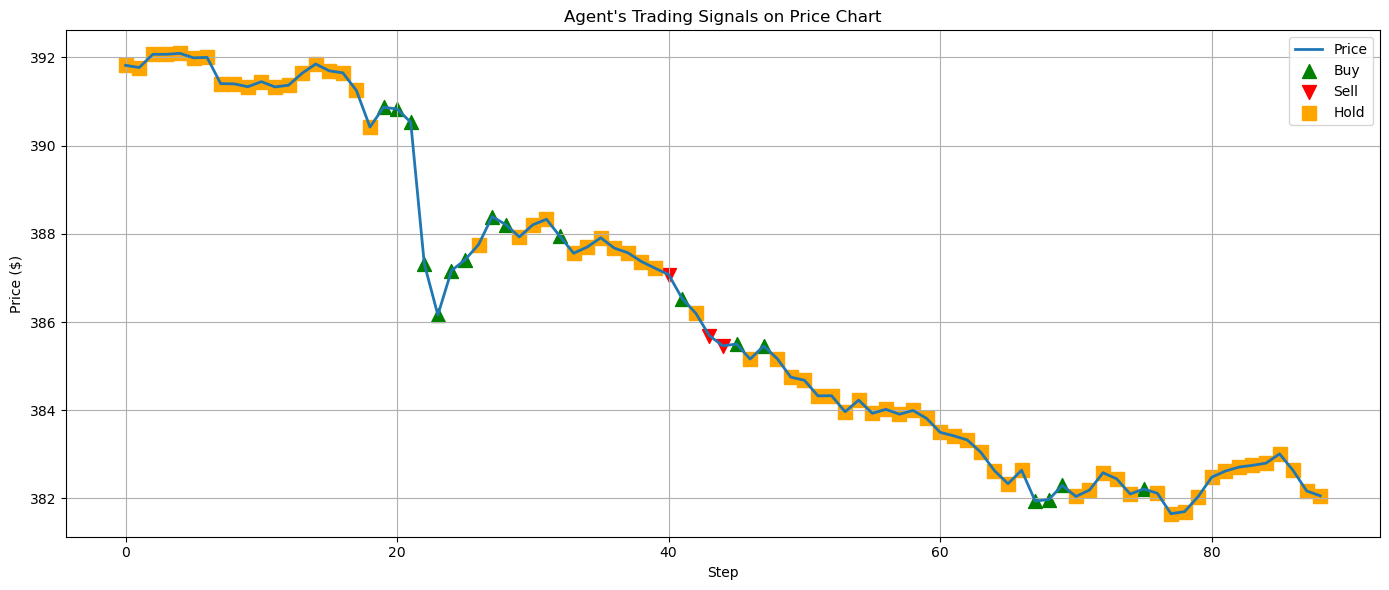

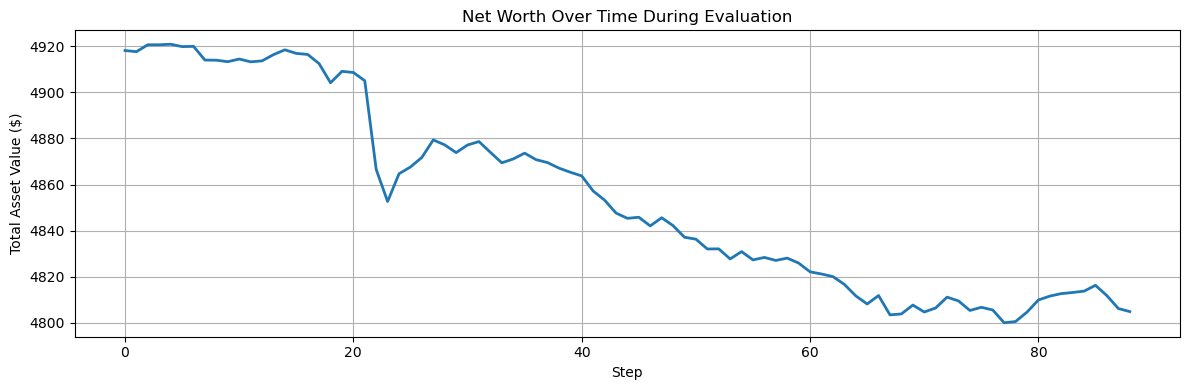

In [28]:
# ----------- Evaluation -------------
test_env = TradingEnv(test_df[:100], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

actions, prices, net_worths = [], [], []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()

# ----------- Plot Trading Signals -------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='s', color='orange', s=100, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------- Plot Net Worth -------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()


Step: 21, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 22, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 23, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 24, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 25, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 26, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 27, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 28, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 29, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 30, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 31, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 32, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)
Step: 33, Cash: 1000.00, Stock: 0, Net Worth: 1000.00, P/L: 0.00 (BREAKEVEN)

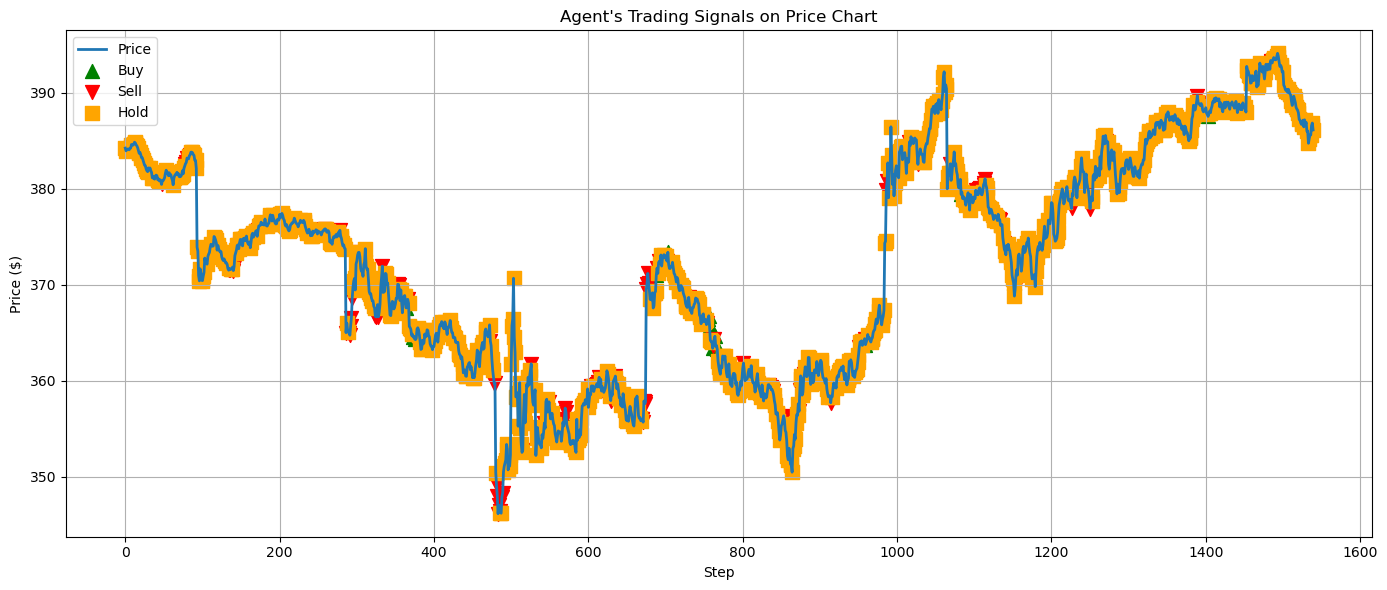

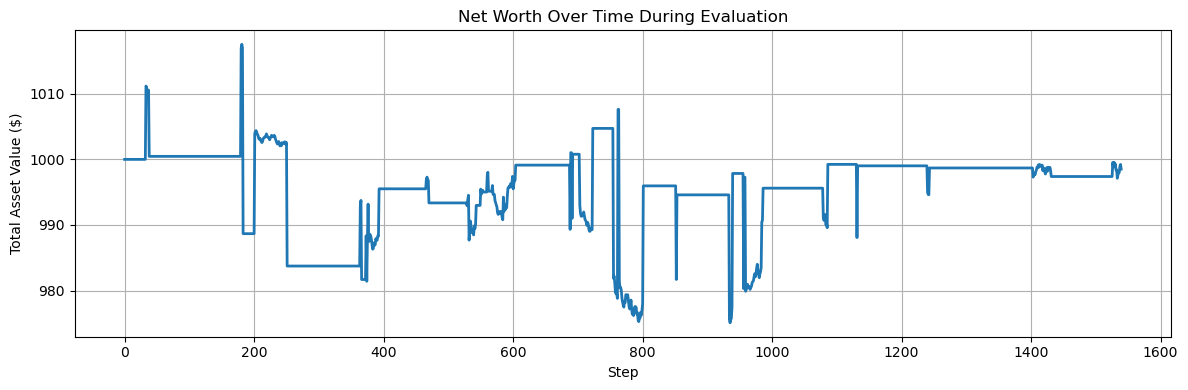

In [53]:
# ----------- Evaluation -------------
test_env = TradingEnv(test_df[300:], context_width=context_width, offset=offset)
obs, _ = test_env.reset()
done = False

actions, prices, net_worths = [], [], []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)

    actions.append(action)
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    prices.append(current_price)
    net_worths.append(current_value)
    test_env.render()

# ----------- Plot Trading Signals -------------
buy_indices = [i for i, a in enumerate(actions) if a == 1]
sell_indices = [i for i, a in enumerate(actions) if a == 2]
hold_indices = [i for i, a in enumerate(actions) if a == 0]

plt.figure(figsize=(14, 6))
plt.plot(prices, label='Price', linewidth=2)
plt.scatter(buy_indices, [prices[i] for i in buy_indices], marker='^', color='g', s=100, label='Buy')
plt.scatter(sell_indices, [prices[i] for i in sell_indices], marker='v', color='r', s=100, label='Sell')
plt.scatter(hold_indices, [prices[i] for i in hold_indices], marker='s', color='orange', s=100, label='Hold')
plt.title("Agent's Trading Signals on Price Chart")
plt.xlabel("Step")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ----------- Plot Net Worth -------------
plt.figure(figsize=(12, 4))
plt.plot(net_worths, label='Net Worth', linewidth=2)
plt.title("Net Worth Over Time During Evaluation")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.grid(True)
plt.tight_layout()
plt.show()
